# Sequential Recommendation: SASRec & gSASRec

This notebook implements and compares sequential recommendation methods:
- **SASRec**
- **gSASRec** 

## 1. Setup and Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os
import json
from collections import defaultdict

from model import SASRec
from data_utils import get_train_dataloader, get_val_dataloader, get_test_dataloader, get_num_items
from metrics import evaluate
from config import ExperimentConfig, get_sasrec_config, get_gsasrec_config
from utils import build_model, get_device
from ir_measures import nDCG, R

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
device = get_device()


Using device: mps


## 2. Dataset Overview

In [3]:
dataset_name = 'ml1m'

with open(f'datasets/{dataset_name}/dataset_stats.json', 'r') as f:
    stats = json.load(f)



Dataset Statistics:
  Users: 6,040
  Items: 3,416
  Interactions: 999,611
  Sparsity: 0.9516


## 3. Training Functions

In [ ]:
def train_epoch(model, train_loader, optimizer, config, device, num_items):
    model.train()
    total_loss = 0
    batches = 0
    
    batch_iter = iter(train_loader)
    batches_per_epoch = min(config.max_batches_per_epoch, len(train_loader))
    
    for _ in tqdm(range(batches_per_epoch), desc='Training'):
        positives, negatives = [tensor.to(device) for tensor in next(batch_iter)]
        model_input = positives[:, :-1]
        last_hidden_state, attentions = model(model_input)
        labels = positives[:, 1:]
        negatives = negatives[:, 1:, :]
        pos_neg_concat = torch.cat([labels.unsqueeze(-1), negatives], dim=-1)
        output_embeddings = model.get_output_embeddings()
        pos_neg_embeddings = output_embeddings(pos_neg_concat)
        mask = (model_input != num_items + 1).float()
        logits = torch.einsum('bse, bsne -> bsn', last_hidden_state, pos_neg_embeddings)
        gt = torch.zeros_like(logits)
        gt[:, :, 0] = 1

        # Apply gBCE transformation if t > 0
        if config.gbce_t > 0:
            temp = 1.0 + config.gbce_t
            logits = logits / temp
        
        loss_per_element = torch.nn.functional.binary_cross_entropy_with_logits(logits, gt, reduction='none').mean(-1)*mask
        loss = loss_per_element.sum() / mask.sum()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        batches += 1
    
    return total_loss / batches


def train_model(config, max_epochs=None, verbose=True):
    if max_epochs is None:
        max_epochs = config.max_epochs
    
    num_items = get_num_items(config.dataset_name)
    model = build_model(config).to(device)
    
    train_loader = get_train_dataloader(
        config.dataset_name,
        batch_size=config.train_batch_size,
        max_length=config.sequence_length,
        train_neg_per_positive=config.negs_per_pos
    )
    val_loader = get_val_dataloader(
        config.dataset_name,
        batch_size=config.eval_batch_size,
        max_length=config.sequence_length
    )
    
    optimizer = torch.optim.Adam(model.parameters())
    
    best_metric = float('-inf')
    best_model_state = None
    epochs_no_improve = 0
    
    history = {
        'train_loss': [],
        'val_ndcg': [],
        'val_recall_1': [],
        'val_recall_10': [],
        'val_precision_10': []
    }
    
    for epoch in range(max_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, config, device, num_items)
        
        val_results = evaluate(
            model, val_loader, config.metrics,
            config.recommendation_limit, config.filter_rated, device
        )
        
        history['train_loss'].append(train_loss)
        history['val_ndcg'].append(float(val_results[nDCG@10]))
        history['val_recall_1'].append(float(val_results[R@1]))
        history['val_recall_10'].append(float(val_results[R@10]))
        history['val_precision_10'].append(float(val_results[P@10]))
        
        if verbose:
            print(f"Epoch {epoch+1}/{max_epochs} | Loss: {train_loss:.4f} | "
                  f"NDCG@10: {val_results[nDCG@10]:.4f} | "
                  f"R@1: {val_results[R@1]:.4f} | R@10: {val_results[R@10]:.4f} | "
                  f"P@10: {val_results[P@10]:.4f}")
        
        current_metric = float(val_results[config.val_metric])
        if current_metric > best_metric:
            best_metric = current_metric
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= config.early_stopping_patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(best_model_state)
    return model, history

## 4. Experiment 1: SASRec vs gSASRec Comparison

Compare vanilla SASRec with gSASRec to understand the impact of:
- More negative samples (1 vs 256)
- Calibrated loss function (BCE vs gBCE)

In [5]:
sasrec_config = get_sasrec_config('ml1m')
sasrec_model, sasrec_history = train_model(sasrec_config, max_epochs=50)

Training SASRec (vanilla)...


100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


Epoch 1/50 | Loss: 3.5634 | NDCG@10: 0.0000 | R@1: 0.0000 | R@10: 0.0000


100%|██████████| 1/1 [00:05<00:00,  5.35s/it]


Epoch 2/50 | Loss: 1.8198 | NDCG@10: 0.0006 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.08s/it]


Epoch 3/50 | Loss: 1.0238 | NDCG@10: 0.0006 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


Epoch 4/50 | Loss: 0.7259 | NDCG@10: 0.0006 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


Epoch 5/50 | Loss: 0.6214 | NDCG@10: 0.0006 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


Epoch 6/50 | Loss: 0.5815 | NDCG@10: 0.0106 | R@1: 0.0000 | R@10: 0.0273


100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


Epoch 7/50 | Loss: 0.5673 | NDCG@10: 0.0149 | R@1: 0.0039 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.31s/it]


Epoch 8/50 | Loss: 0.5609 | NDCG@10: 0.0139 | R@1: 0.0039 | R@10: 0.0312


100%|██████████| 1/1 [00:05<00:00,  5.52s/it]


Epoch 9/50 | Loss: 0.5581 | NDCG@10: 0.0160 | R@1: 0.0020 | R@10: 0.0352


100%|██████████| 1/1 [00:05<00:00,  5.32s/it]


Epoch 10/50 | Loss: 0.5565 | NDCG@10: 0.0177 | R@1: 0.0039 | R@10: 0.0371


100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


Epoch 11/50 | Loss: 0.5558 | NDCG@10: 0.0128 | R@1: 0.0059 | R@10: 0.0234


100%|██████████| 1/1 [00:05<00:00,  5.68s/it]


Epoch 12/50 | Loss: 0.5537 | NDCG@10: 0.0206 | R@1: 0.0078 | R@10: 0.0391


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


Epoch 13/50 | Loss: 0.5531 | NDCG@10: 0.0142 | R@1: 0.0059 | R@10: 0.0273


100%|██████████| 1/1 [00:05<00:00,  5.07s/it]


Epoch 14/50 | Loss: 0.5526 | NDCG@10: 0.0154 | R@1: 0.0059 | R@10: 0.0312


100%|██████████| 1/1 [00:05<00:00,  5.51s/it]


Epoch 15/50 | Loss: 0.5520 | NDCG@10: 0.0184 | R@1: 0.0059 | R@10: 0.0391


100%|██████████| 1/1 [00:05<00:00,  5.33s/it]


Epoch 16/50 | Loss: 0.5528 | NDCG@10: 0.0205 | R@1: 0.0078 | R@10: 0.0391


100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


Epoch 17/50 | Loss: 0.5516 | NDCG@10: 0.0113 | R@1: 0.0020 | R@10: 0.0234


100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


Epoch 18/50 | Loss: 0.5501 | NDCG@10: 0.0163 | R@1: 0.0059 | R@10: 0.0332


100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


Epoch 19/50 | Loss: 0.5492 | NDCG@10: 0.0147 | R@1: 0.0039 | R@10: 0.0273


100%|██████████| 1/1 [00:05<00:00,  5.09s/it]


Epoch 20/50 | Loss: 0.5495 | NDCG@10: 0.0144 | R@1: 0.0059 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.67s/it]


Epoch 21/50 | Loss: 0.5493 | NDCG@10: 0.0173 | R@1: 0.0059 | R@10: 0.0332


100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


Epoch 22/50 | Loss: 0.5482 | NDCG@10: 0.0190 | R@1: 0.0098 | R@10: 0.0332


100%|██████████| 1/1 [00:05<00:00,  5.24s/it]


Epoch 23/50 | Loss: 0.5474 | NDCG@10: 0.0235 | R@1: 0.0098 | R@10: 0.0449


100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


Epoch 24/50 | Loss: 0.5467 | NDCG@10: 0.0122 | R@1: 0.0059 | R@10: 0.0234


100%|██████████| 1/1 [00:04<00:00,  4.85s/it]


Epoch 25/50 | Loss: 0.5474 | NDCG@10: 0.0186 | R@1: 0.0059 | R@10: 0.0391


100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


Epoch 26/50 | Loss: 0.5472 | NDCG@10: 0.0195 | R@1: 0.0078 | R@10: 0.0352


100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


Epoch 27/50 | Loss: 0.5475 | NDCG@10: 0.0125 | R@1: 0.0020 | R@10: 0.0254


100%|██████████| 1/1 [00:05<00:00,  5.47s/it]


Epoch 28/50 | Loss: 0.5467 | NDCG@10: 0.0191 | R@1: 0.0039 | R@10: 0.0410


100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


Epoch 29/50 | Loss: 0.5466 | NDCG@10: 0.0143 | R@1: 0.0059 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.54s/it]


Epoch 30/50 | Loss: 0.5452 | NDCG@10: 0.0185 | R@1: 0.0078 | R@10: 0.0332


100%|██████████| 1/1 [00:05<00:00,  5.28s/it]


Epoch 31/50 | Loss: 0.5462 | NDCG@10: 0.0150 | R@1: 0.0039 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


Epoch 32/50 | Loss: 0.5465 | NDCG@10: 0.0112 | R@1: 0.0020 | R@10: 0.0273


100%|██████████| 1/1 [00:05<00:00,  5.08s/it]


Epoch 33/50 | Loss: 0.5472 | NDCG@10: 0.0162 | R@1: 0.0078 | R@10: 0.0273


100%|██████████| 1/1 [00:04<00:00,  4.92s/it]


Epoch 34/50 | Loss: 0.5451 | NDCG@10: 0.0187 | R@1: 0.0039 | R@10: 0.0430


100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


Epoch 35/50 | Loss: 0.5452 | NDCG@10: 0.0194 | R@1: 0.0039 | R@10: 0.0391


100%|██████████| 1/1 [00:05<00:00,  5.68s/it]


Epoch 36/50 | Loss: 0.5446 | NDCG@10: 0.0172 | R@1: 0.0059 | R@10: 0.0312


100%|██████████| 1/1 [00:05<00:00,  5.50s/it]


Epoch 37/50 | Loss: 0.5455 | NDCG@10: 0.0139 | R@1: 0.0039 | R@10: 0.0273


100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


Epoch 38/50 | Loss: 0.5446 | NDCG@10: 0.0144 | R@1: 0.0039 | R@10: 0.0312


100%|██████████| 1/1 [00:05<00:00,  5.33s/it]


Epoch 39/50 | Loss: 0.5436 | NDCG@10: 0.0175 | R@1: 0.0059 | R@10: 0.0352


100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


Epoch 40/50 | Loss: 0.5438 | NDCG@10: 0.0162 | R@1: 0.0039 | R@10: 0.0332


100%|██████████| 1/1 [00:05<00:00,  5.25s/it]


Epoch 41/50 | Loss: 0.5436 | NDCG@10: 0.0101 | R@1: 0.0020 | R@10: 0.0254


100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


Epoch 42/50 | Loss: 0.5419 | NDCG@10: 0.0217 | R@1: 0.0059 | R@10: 0.0410


100%|██████████| 1/1 [00:05<00:00,  5.28s/it]


Epoch 43/50 | Loss: 0.5427 | NDCG@10: 0.0202 | R@1: 0.0059 | R@10: 0.0391


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


Epoch 44/50 | Loss: 0.5427 | NDCG@10: 0.0176 | R@1: 0.0039 | R@10: 0.0410


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


Epoch 45/50 | Loss: 0.5435 | NDCG@10: 0.0132 | R@1: 0.0039 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


Epoch 46/50 | Loss: 0.5418 | NDCG@10: 0.0162 | R@1: 0.0039 | R@10: 0.0352


100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


Epoch 47/50 | Loss: 0.5428 | NDCG@10: 0.0141 | R@1: 0.0020 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.25s/it]


Epoch 48/50 | Loss: 0.5418 | NDCG@10: 0.0170 | R@1: 0.0078 | R@10: 0.0332


100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


Epoch 49/50 | Loss: 0.5415 | NDCG@10: 0.0128 | R@1: 0.0059 | R@10: 0.0254


100%|██████████| 1/1 [00:05<00:00,  5.19s/it]

Epoch 50/50 | Loss: 0.5417 | NDCG@10: 0.0175 | R@1: 0.0059 | R@10: 0.0352


In [13]:
gsasrec_config = get_gsasrec_config('ml1m')
gsasrec_model, gsasrec_history = train_model(gsasrec_config, max_epochs=50)

Training gSASRec...


100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


Epoch 1/50 | Loss: 2.6972 | NDCG@10: 0.0010 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.56s/it]


Epoch 2/50 | Loss: 0.8446 | NDCG@10: 0.0010 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.69s/it]


Epoch 3/50 | Loss: 0.2593 | NDCG@10: 0.0010 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.48s/it]


Epoch 4/50 | Loss: 0.0801 | NDCG@10: 0.0010 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.72s/it]


Epoch 5/50 | Loss: 0.0358 | NDCG@10: 0.0012 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


Epoch 6/50 | Loss: 0.0252 | NDCG@10: 0.0012 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


Epoch 7/50 | Loss: 0.0214 | NDCG@10: 0.0010 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.30s/it]


Epoch 8/50 | Loss: 0.0195 | NDCG@10: 0.0010 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


Epoch 9/50 | Loss: 0.0179 | NDCG@10: 0.0010 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


Epoch 10/50 | Loss: 0.0168 | NDCG@10: 0.0010 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


Epoch 11/50 | Loss: 0.0161 | NDCG@10: 0.0008 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


Epoch 12/50 | Loss: 0.0153 | NDCG@10: 0.0007 | R@1: 0.0000 | R@10: 0.0020


100%|██████████| 1/1 [00:05<00:00,  5.56s/it]


Epoch 13/50 | Loss: 0.0148 | NDCG@10: 0.0018 | R@1: 0.0000 | R@10: 0.0059


100%|██████████| 1/1 [00:05<00:00,  5.34s/it]


Epoch 14/50 | Loss: 0.0142 | NDCG@10: 0.0027 | R@1: 0.0000 | R@10: 0.0059


100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


Epoch 15/50 | Loss: 0.0139 | NDCG@10: 0.0045 | R@1: 0.0020 | R@10: 0.0078


100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


Epoch 16/50 | Loss: 0.0135 | NDCG@10: 0.0079 | R@1: 0.0039 | R@10: 0.0156


100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


Epoch 17/50 | Loss: 0.0132 | NDCG@10: 0.0124 | R@1: 0.0039 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.40s/it]


Epoch 18/50 | Loss: 0.0129 | NDCG@10: 0.0187 | R@1: 0.0059 | R@10: 0.0410


100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


Epoch 19/50 | Loss: 0.0126 | NDCG@10: 0.0168 | R@1: 0.0059 | R@10: 0.0352


100%|██████████| 1/1 [00:05<00:00,  5.49s/it]


Epoch 20/50 | Loss: 0.0123 | NDCG@10: 0.0151 | R@1: 0.0039 | R@10: 0.0312


100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


Epoch 21/50 | Loss: 0.0122 | NDCG@10: 0.0175 | R@1: 0.0059 | R@10: 0.0352


100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


Epoch 22/50 | Loss: 0.0120 | NDCG@10: 0.0159 | R@1: 0.0039 | R@10: 0.0371


100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


Epoch 23/50 | Loss: 0.0117 | NDCG@10: 0.0172 | R@1: 0.0059 | R@10: 0.0352


100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


Epoch 24/50 | Loss: 0.0115 | NDCG@10: 0.0180 | R@1: 0.0059 | R@10: 0.0391


100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


Epoch 25/50 | Loss: 0.0114 | NDCG@10: 0.0163 | R@1: 0.0039 | R@10: 0.0371


100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


Epoch 26/50 | Loss: 0.0112 | NDCG@10: 0.0140 | R@1: 0.0039 | R@10: 0.0332


100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


Epoch 27/50 | Loss: 0.0110 | NDCG@10: 0.0126 | R@1: 0.0020 | R@10: 0.0312


100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


Epoch 28/50 | Loss: 0.0109 | NDCG@10: 0.0136 | R@1: 0.0020 | R@10: 0.0332


100%|██████████| 1/1 [00:05<00:00,  5.33s/it]


Epoch 29/50 | Loss: 0.0107 | NDCG@10: 0.0142 | R@1: 0.0020 | R@10: 0.0371


100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


Epoch 30/50 | Loss: 0.0106 | NDCG@10: 0.0108 | R@1: 0.0020 | R@10: 0.0254


100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


Epoch 31/50 | Loss: 0.0105 | NDCG@10: 0.0121 | R@1: 0.0020 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.97s/it]


Epoch 32/50 | Loss: 0.0104 | NDCG@10: 0.0151 | R@1: 0.0020 | R@10: 0.0371


100%|██████████| 1/1 [00:05<00:00,  5.54s/it]


Epoch 33/50 | Loss: 0.0103 | NDCG@10: 0.0123 | R@1: 0.0039 | R@10: 0.0273


100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


Epoch 34/50 | Loss: 0.0102 | NDCG@10: 0.0156 | R@1: 0.0020 | R@10: 0.0391


100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


Epoch 35/50 | Loss: 0.0101 | NDCG@10: 0.0127 | R@1: 0.0020 | R@10: 0.0312


100%|██████████| 1/1 [00:05<00:00,  5.52s/it]


Epoch 36/50 | Loss: 0.0100 | NDCG@10: 0.0142 | R@1: 0.0020 | R@10: 0.0352


100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


Epoch 37/50 | Loss: 0.0099 | NDCG@10: 0.0124 | R@1: 0.0020 | R@10: 0.0312


100%|██████████| 1/1 [00:05<00:00,  5.49s/it]


Epoch 38/50 | Loss: 0.0099 | NDCG@10: 0.0127 | R@1: 0.0020 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


Epoch 39/50 | Loss: 0.0098 | NDCG@10: 0.0147 | R@1: 0.0039 | R@10: 0.0352


100%|██████████| 1/1 [00:04<00:00,  4.98s/it]


Epoch 40/50 | Loss: 0.0097 | NDCG@10: 0.0137 | R@1: 0.0020 | R@10: 0.0352


100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


Epoch 41/50 | Loss: 0.0097 | NDCG@10: 0.0142 | R@1: 0.0020 | R@10: 0.0332


100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


Epoch 42/50 | Loss: 0.0096 | NDCG@10: 0.0146 | R@1: 0.0020 | R@10: 0.0352


100%|██████████| 1/1 [00:05<00:00,  5.52s/it]


Epoch 43/50 | Loss: 0.0096 | NDCG@10: 0.0128 | R@1: 0.0020 | R@10: 0.0312


100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


Epoch 44/50 | Loss: 0.0095 | NDCG@10: 0.0140 | R@1: 0.0020 | R@10: 0.0332


100%|██████████| 1/1 [00:05<00:00,  5.42s/it]


Epoch 45/50 | Loss: 0.0095 | NDCG@10: 0.0136 | R@1: 0.0039 | R@10: 0.0312


100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


Epoch 46/50 | Loss: 0.0094 | NDCG@10: 0.0147 | R@1: 0.0020 | R@10: 0.0332


100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


Epoch 47/50 | Loss: 0.0094 | NDCG@10: 0.0127 | R@1: 0.0020 | R@10: 0.0312


100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


Epoch 48/50 | Loss: 0.0094 | NDCG@10: 0.0124 | R@1: 0.0020 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.15s/it]


Epoch 49/50 | Loss: 0.0093 | NDCG@10: 0.0133 | R@1: 0.0039 | R@10: 0.0293


100%|██████████| 1/1 [00:05<00:00,  5.03s/it]

Epoch 50/50 | Loss: 0.0093 | NDCG@10: 0.0125 | R@1: 0.0020 | R@10: 0.0312


### 4.1 Training Curves Comparison

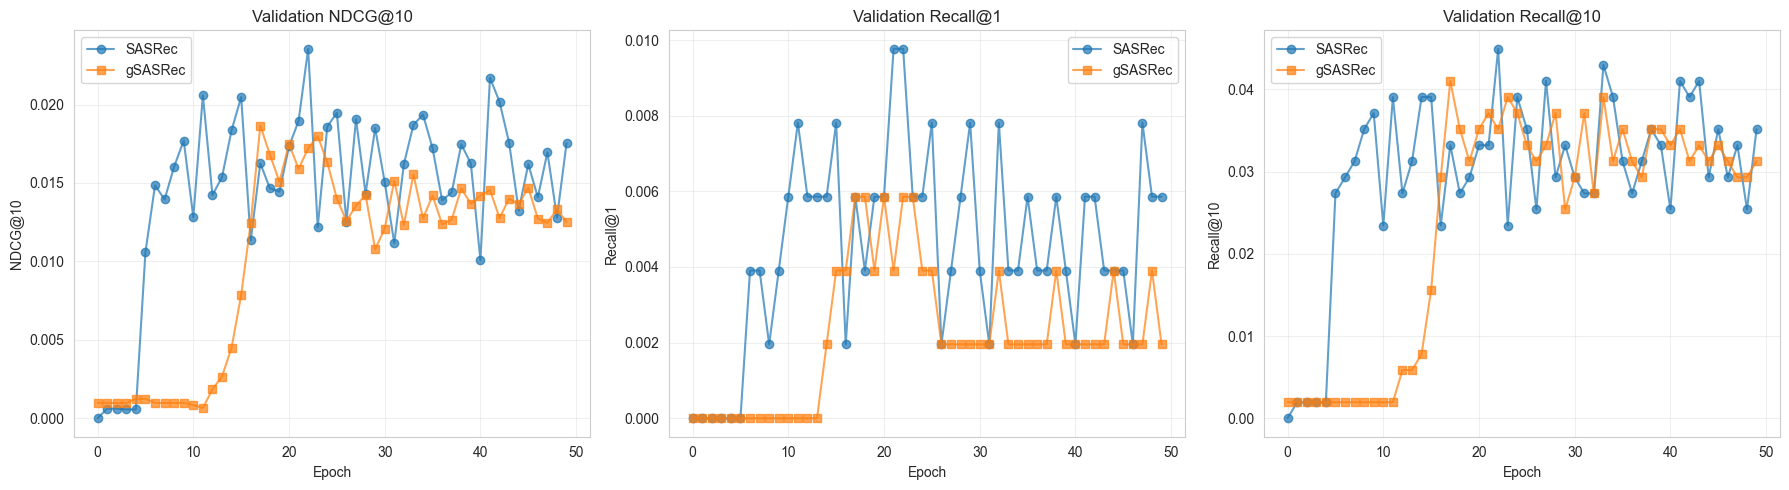

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(sasrec_history['val_ndcg'], label='SASRec', marker='o', alpha=0.7)
axes[0].plot(gsasrec_history['val_ndcg'], label='gSASRec', marker='s', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('NDCG@10')
axes[0].set_title('Validation NDCG@10')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(sasrec_history['val_recall_1'], label='SASRec', marker='o', alpha=0.7)
axes[1].plot(gsasrec_history['val_recall_1'], label='gSASRec', marker='s', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Recall@1')
axes[1].set_title('Validation Recall@1')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(sasrec_history['val_recall_10'], label='SASRec', marker='o', alpha=0.7)
axes[2].plot(gsasrec_history['val_recall_10'], label='gSASRec', marker='s', alpha=0.7)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Recall@10')
axes[2].set_title('Validation Recall@10')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Test Set Evaluation

In [ ]:
test_loader = get_test_dataloader('ml1m', batch_size=512, max_length=200)

sasrec_test_results = evaluate(
    sasrec_model, test_loader,
    [nDCG@10, R@1, R@10],
    10, True, device
)

gsasrec_test_results = evaluate(
    gsasrec_model, test_loader,
    [nDCG@10, R@1, R@10],
    10, True, device
)

results_df = pd.DataFrame({
    'Model': ['SASRec', 'gSASRec'],
    'NDCG@10': [float(sasrec_test_results[nDCG@10]), float(gsasrec_test_results[nDCG@10])],
    'Recall@1': [float(sasrec_test_results[R@1]), float(gsasrec_test_results[R@1])],
    'Recall@10': [float(sasrec_test_results[R@10]), float(gsasrec_test_results[R@10])]
})



## 5. Ablation Study: Impact of Key Components

Analyze which components contribute most to gSASRec's performance:
1. Number of negative samples
2. Calibration parameter t
3. Embedding reuse strategy

### 5.1 Number of Negative Samples

In [ ]:
neg_samples = [1, 32, 64, 128, 256]
neg_results = []

for n_negs in neg_samples:
    config = ExperimentConfig(
        dataset_name='ml1m',
        embedding_dim=128,
        num_heads=1,
        num_blocks=2,
        dropout_rate=0.5,
        negs_per_pos=n_negs,
        gbce_t=0.75,
        max_batches_per_epoch=50
    )
    model, history = train_model(config, max_epochs=30, verbose=False)

    test_results = evaluate(model, test_loader, [nDCG@10, R@10], 10, True, device)
    neg_results.append({
        'n_negs': n_negs,
        'ndcg': float(test_results[nDCG@10]),
        'recall': float(test_results[R@10])
    })

neg_df = pd.DataFrame(neg_results)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(neg_df['n_negs'], neg_df['ndcg'], marker='o', linewidth=2)
axes[0].set_xlabel('Number of Negative Samples')
axes[0].set_ylabel('NDCG@10')
axes[0].set_title('Impact of Negative Sampling')
axes[0].set_xscale('log', base=2)
axes[0].grid(True, alpha=0.3)

axes[1].plot(neg_df['n_negs'], neg_df['recall'], marker='o', linewidth=2, color='orange')
axes[1].set_xlabel('Number of Negative Samples')
axes[1].set_ylabel('Recall@10')
axes[1].set_title('Impact of Negative Sampling')
axes[1].set_xscale('log', base=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Calibration Parameter t

In [ ]:
t_values = [0.0, 0.25, 0.5, 0.75, 1.0]
t_results = []

for t in t_values:
    config = ExperimentConfig(
        dataset_name='ml1m',
        embedding_dim=128,
        num_heads=1,
        num_blocks=2,
        dropout_rate=0.5,
        negs_per_pos=256,
        gbce_t=t,
        max_batches_per_epoch=50
    )
    model, history = train_model(config, max_epochs=30, verbose=False)

    test_results = evaluate(model, test_loader, [nDCG@10, R@10], 10, True, device)
    t_results.append({
        't': t,
        'ndcg': float(test_results[nDCG@10]),
        'recall': float(test_results[R@10])
    })

t_df = pd.DataFrame(t_results)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(t_df['t'], t_df['ndcg'], marker='o', linewidth=2)
axes[0].set_xlabel('Calibration Parameter t')
axes[0].set_ylabel('NDCG@10')
axes[0].set_title('Impact of Loss Calibration')
axes[0].grid(True, alpha=0.3)

axes[1].plot(t_df['t'], t_df['recall'], marker='o', linewidth=2, color='orange')
axes[1].set_xlabel('Calibration Parameter t')
axes[1].set_ylabel('Recall@10')
axes[1].set_title('Impact of Loss Calibration')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Parameter Sensitivity Analysis

Study the impact of model hyperparameters

### 6.1 Embedding Dimension

In [ ]:
embedding_dims = [32, 64, 128, 256]
emb_results = []

for emb_dim in embedding_dims:
    config = get_gsasrec_config('ml1m')
    config.embedding_dim = emb_dim
    config.max_batches_per_epoch = 50

    model, history = train_model(config, max_epochs=30, verbose=False)
    test_results = evaluate(model, test_loader, [nDCG@10, R@10], 10, True, device)

    emb_results.append({
        'emb_dim': emb_dim,
        'ndcg': float(test_results[nDCG@10]),
        'recall': float(test_results[R@10])
    })

emb_df = pd.DataFrame(emb_results)

### 6.2 Number of Transformer Blocks

In [ ]:
num_blocks_list = [1, 2, 3, 4]
blocks_results = []

for n_blocks in num_blocks_list:
    config = get_gsasrec_config('ml1m')
    config.num_blocks = n_blocks
    config.max_batches_per_epoch = 50

    model, history = train_model(config, max_epochs=30, verbose=False)
    test_results = evaluate(model, test_loader, [nDCG@10, R@10], 10, True, device)

    blocks_results.append({
        'n_blocks': n_blocks,
        'ndcg': float(test_results[nDCG@10]),
        'recall': float(test_results[R@10])
    })

blocks_df = pd.DataFrame(blocks_results)

### 6.3 Dropout Rate

In [ ]:
dropout_rates = [0.0, 0.2, 0.3, 0.5, 0.7]
dropout_results = []

for dropout in dropout_rates:
    config = get_gsasrec_config('ml1m')
    config.dropout_rate = dropout
    config.max_batches_per_epoch = 50

    model, history = train_model(config, max_epochs=30, verbose=False)
    test_results = evaluate(model, test_loader, [nDCG@10, R@10], 10, True, device)

    dropout_results.append({
        'dropout': dropout,
        'ndcg': float(test_results[nDCG@10]),
        'recall': float(test_results[R@10])
    })

dropout_df = pd.DataFrame(dropout_results)

### 6.4 Parameter Sensitivity Visualization

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(emb_df['emb_dim'], emb_df['ndcg'], marker='o', linewidth=2)
axes[0].set_xlabel('Embedding Dimension')
axes[0].set_ylabel('NDCG@10')
axes[0].set_title('Embedding Dimension Sensitivity')
axes[0].grid(True, alpha=0.3)

axes[1].plot(blocks_df['n_blocks'], blocks_df['ndcg'], marker='o', linewidth=2)
axes[1].set_xlabel('Number of Transformer Blocks')
axes[1].set_ylabel('NDCG@10')
axes[1].set_title('Model Depth Sensitivity')
axes[1].grid(True, alpha=0.3)

axes[2].plot(dropout_df['dropout'], dropout_df['ndcg'], marker='o', linewidth=2)
axes[2].set_xlabel('Dropout Rate')
axes[2].set_ylabel('NDCG@10')
axes[2].set_title('Dropout Sensitivity')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary of Results

Consolidate all experimental findings

In [ ]:
summary = {
    'Best Config': {
        'embedding_dim': int(emb_df.loc[emb_df['ndcg'].idxmax(), 'emb_dim']),
        'num_blocks': int(blocks_df.loc[blocks_df['ndcg'].idxmax(), 'n_blocks']),
        'dropout': float(dropout_df.loc[dropout_df['ndcg'].idxmax(), 'dropout']),
        'negs_per_pos': int(neg_df.loc[neg_df['ndcg'].idxmax(), 'n_negs']),
        'gbce_t': float(t_df.loc[t_df['ndcg'].idxmax(), 't'])
    }
}

for key, value in summary['Best Config'].items():


## 8. Discussion

### Key Findings:

1. **gSASRec Improvements**: [Analyze the performance gap]
2. **Negative Sampling**: [Discuss the impact of more negatives]
3. **Calibration**: [Explain the role of t parameter]
4. **Optimal Parameters**: [Recommendations for hyperparameters]
5. **Computational Trade-offs**: [Training time vs performance]

### Strengths and Weaknesses:

**SASRec Strengths**:
- Faster training (fewer negatives)
- Simpler to tune

**SASRec Weaknesses**:
- Lower performance
- Overconfident predictions

**gSASRec Strengths**:
- Better recommendation quality
- Calibrated probabilities
- More robust to hyperparameters

**gSASRec Weaknesses**:
- Slower training
- More memory intensive

# Amazon Electronics with gSASRec: From Scratch

This section is self-contained: it preprocesses the Amazon Electronics CSV to SASRec format (next-item and next-basket), builds loaders, trains gSASRec, and evaluates with leave-last splits.


In [25]:
# 1) Preprocess to SASRec format (idempotent)
import os, subprocess, json

root_csv = os.path.join('..', 'ratings_Electronics (1).csv')
dataset_item = 'ratings_Electronics_1'
dataset_basket = 'ratings_Electronics_1_nb'
out_dir_item = os.path.join('datasets', dataset_item)
out_dir_basket = os.path.join('datasets', dataset_basket)

def run_preprocess(target, out_dir):
    if os.path.exists(out_dir) and os.path.exists(os.path.join(out_dir, 'dataset_stats.json')):
        print(f'Exists: {out_dir}')
        return
    cmd = [
        'python3', 'preprocess_csv.py',
        '--input_csv', root_csv,
        '--output_dir', out_dir,
        '--target', target,
        '--positive-threshold', '4.0',
        '--min-user-interactions', '5', '--min-item-interactions', '5',
        '--max-seq-len', '50'
    ]
    print('Running:', ' '.join(cmd))
    subprocess.run(cmd, check=True)

run_preprocess('next-item', out_dir_item)
run_preprocess('next-basket', out_dir_basket)

print('next-item stats:', json.load(open(os.path.join(out_dir_item, 'dataset_stats.json'))))
print('next-basket stats:', json.load(open(os.path.join(out_dir_basket, 'dataset_stats.json'))))


Exists: datasets/ratings_Electronics_1
Exists: datasets/ratings_Electronics_1_nb
next-item stats: {'num_users': 124895, 'num_items': 44843, 'num_interactions': 1072740, 'target': 'next-item', 'max_seq_len': 50, 'pad_token_id': 44844}
next-basket stats: {'num_users': 118620, 'num_items': 44843, 'num_interactions': 1072740, 'target': 'next-basket', 'max_seq_len': 50, 'pad_token_id': 44844}


In [26]:
# 2) Imports, config, model factory, and helpers
import math, time, random
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from tqdm import tqdm

from model import SASRec as GSASRec
from data_utils import (
    get_train_dataloader, get_val_dataloader, get_test_dataloader, get_padding_value
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_stats(dataset_dir):
    with open(os.path.join(dataset_dir, 'dataset_stats.json'), 'r') as f:
        return json.load(f)

def build_model(num_items, seq_len, d_model=128, n_heads=4, n_blocks=2, dropout=0.1):
    model = GSASRec(
        num_items=num_items,
        sequence_length=seq_len,
        embedding_dim=d_model,
        num_heads=n_heads,
        num_blocks=n_blocks,
        dropout_rate=dropout,
        reuse_item_embeddings=True
    )
    return model.to(device)

def metrics_at_k(topk, targets):
    # targets: list[list[int]]
    K = topk.shape[1]
    precisions, recalls, ndcgs = [], [], []
    for i, recs in enumerate(topk.tolist()):
        rel = set(targets[i])
        if not rel:
            continue
        hits = [1 if r in rel else 0 for r in recs]
        p = sum(hits) / K
        r = sum(hits) / len(rel)
        # nDCG
        dcg = 0.0
        for j, h in enumerate(hits, start=1):
            if h:
                dcg += 1.0 / math.log2(j + 1)
        # ideal DCG with |rel| at top
        ideal_hits = min(len(rel), K)
        idcg = sum(1.0 / math.log2(j + 1) for j in range(1, ideal_hits + 1)) or 1.0
        ndcgs.append(dcg / idcg)
        precisions.append(p)
        recalls.append(r)
    return {
        'Precision@{}'.format(K): float(np.mean(precisions) if precisions else 0.0),
        'Recall@{}'.format(K): float(np.mean(recalls) if recalls else 0.0),
        'nDCG@{}'.format(K): float(np.mean(ndcgs) if ndcgs else 0.0),
    }


In [27]:
# 3) Training loop (gSASRec objective: sampled softmax per timestep)
def train_epoch(model, train_loader, optimizer, pad_id, K=64, tau=0.6):
    model.train()
    total_loss = 0.0
    steps = 0
    output_embed = model.get_output_embeddings()
    for batch in tqdm(train_loader, desc='Training'):
        inputs, negs = batch  # [B,S+1], [B,S+1,K]
        inputs = inputs.to(device)
        negs = negs.to(device)
        # Align lengths: X=S, labels=S, negs=S
        X = inputs[:, :-1]
        labels = inputs[:, 1:]
        negs = negs[:, 1:, :]
        mask = (labels != pad_id)
        h, _ = model(X)                     # [B,S,E]
        pos_e = output_embed(labels)        # [B,S,E]
        neg_e = output_embed(negs)          # [B,S,K,E]
        pos_logits = torch.einsum('bse,bse->bs', h, pos_e)
        neg_logits = torch.einsum('bse,bske->bsk', h, neg_e)
        logits = torch.cat([pos_logits.unsqueeze(2), neg_logits], dim=2)  # [B,S,1+K]
        logits = logits / tau
        # Targets: 0 index is positive
        target = torch.zeros_like(logits[..., 0], dtype=torch.long, device=logits.device)
        # Mask out PAD positions
        logits = logits[mask]
        target = target[mask]
        loss = nn.CrossEntropyLoss()(logits, target)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
        steps += 1
    return total_loss / max(steps, 1)

def rank_topk(model, inputs, K, pad_id, filter_rated=True, rated_sets=None):
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        H, _ = model(inputs)
        hS = H[:, -1, :]                              # [B,E]
        W = model.get_output_embeddings().weight      # [V,E]
        scores = torch.matmul(hS, W.t())              # [B,V]
        # Mask invalid tokens: 0 and > pad_id
        scores[:, 0] = float('-inf')
        if scores.shape[1] > pad_id + 1:
            scores[:, pad_id+1:] = float('-inf')
        # Optionally mask seen items
        if filter_rated and rated_sets is not None:
            for i, rated in enumerate(rated_sets):
                if rated:
                    idx = torch.tensor(list(rated), device=scores.device)
                    idx = idx[(idx >= 1) & (idx <= pad_id-1)]
                    scores[i, idx] = float('-inf')
        topk = torch.topk(scores, K, dim=1).indices
        return topk

def evaluate_loader(model, data_loader, K, pad_id, filter_rated=True):
    all_topk = []
    all_targets = []
    for inputs, rated, targets in data_loader:
        topk = rank_topk(model, inputs, K, pad_id, filter_rated=filter_rated, rated_sets=rated)
        all_topk.append(topk.cpu())
        all_targets.extend(targets)
    all_topk = torch.cat(all_topk, dim=0) if all_topk else torch.empty(0, K)
    return metrics_at_k(all_topk, all_targets)


In [28]:
# 4) Configure datasets and hyperparameters
SEQ_LEN = 50
BATCH = 128
EMB = 128
LAYERS = 2
HEADS = 4
DROPOUT = 0.1
NEGS = 64
TAU = 0.6
LR = 1e-4
EPOCHS = 5  # increase for better results
TOPK = 10

ds_item = dataset_item
ds_basket = dataset_basket
pad_item = get_padding_value(os.path.join('datasets', ds_item))
num_items_item = load_stats(os.path.join('datasets', ds_item))['num_items']
pad_basket = get_padding_value(os.path.join('datasets', ds_basket))
num_items_basket = load_stats(os.path.join('datasets', ds_basket))['num_items']


In [29]:
# 5) Train and evaluate on next-item
train_loader = get_train_dataloader(ds_item, batch_size=BATCH, max_length=SEQ_LEN, train_neg_per_positive=NEGS)
val_loader = get_val_dataloader(ds_item, batch_size=BATCH, max_length=SEQ_LEN)
test_loader = get_test_dataloader(ds_item, batch_size=BATCH, max_length=SEQ_LEN)

model_item = build_model(num_items_item, SEQ_LEN, d_model=EMB, n_heads=HEADS, n_blocks=LAYERS, dropout=DROPOUT)
opt = AdamW(model_item.parameters(), lr=LR, weight_decay=1e-4)

best_val = -1.0
best_state = None
for epoch in range(1, EPOCHS+1):
    print(f'=== Epoch {epoch}/{EPOCHS} ===', flush=True)
    loss = train_epoch(model_item, train_loader, opt, pad_item, K=NEGS, tau=TAU)
    print(f'[Epoch {epoch}] train_loss={loss:.4f}', flush=True)
    val_metrics = evaluate_loader(model_item, val_loader, TOPK, pad_item, filter_rated=True)
    print(f'[Epoch {epoch}] val@{TOPK}: {val_metrics}', flush=True)
    ndcg = val_metrics.get(f'nDCG@{TOPK}', 0.0)
    if ndcg > best_val:
        best_val = ndcg
        best_state = {k: v.cpu() for k, v in model_item.state_dict().items()}

if best_state is not None:
    model_item.load_state_dict(best_state)

test_metrics = evaluate_loader(model_item, test_loader, TOPK, pad_item, filter_rated=True)
print('Test (next-item):', test_metrics)


=== Epoch 1/5 ===


Training:   5%|▍         | 47/976 [00:10<03:21,  4.61it/s]


KeyboardInterrupt: 

In [ ]:
# 6) Evaluate next-basket (train similarly if desired)
# Option A: reuse the next-item trained model to score baskets
basket_val = get_val_dataloader(ds_basket, batch_size=BATCH, max_length=SEQ_LEN)
basket_test = get_test_dataloader(ds_basket, batch_size=BATCH, max_length=SEQ_LEN)
basket_metrics_val = evaluate_loader(model_item, basket_val, TOPK, pad_basket, filter_rated=True)
basket_metrics_test = evaluate_loader(model_item, basket_test, TOPK, pad_basket, filter_rated=True)
print('Val (next-basket):', basket_metrics_val)
print('Test (next-basket):', basket_metrics_test)

# Option B (optional): train a separate model on the basket dataset by swapping ds_item->ds_basket above.
